
Code name: all_old
Excluded results due to missing fields: 0


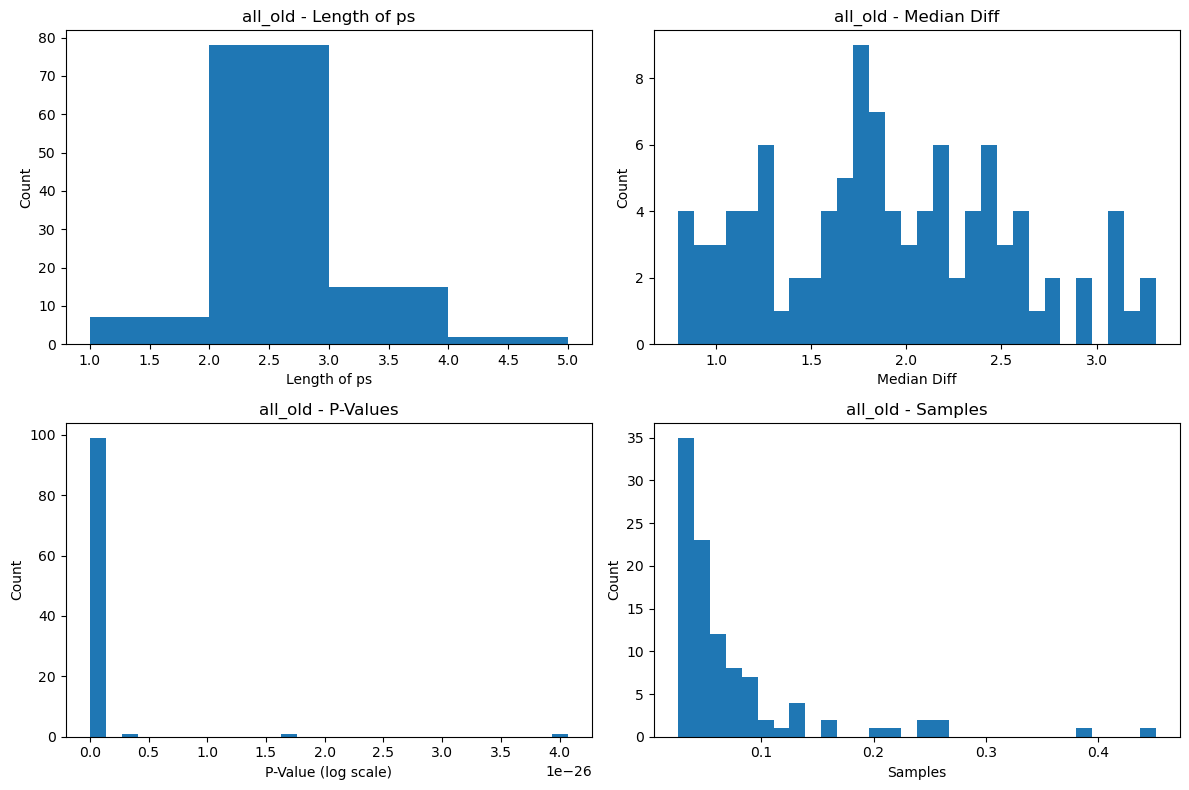

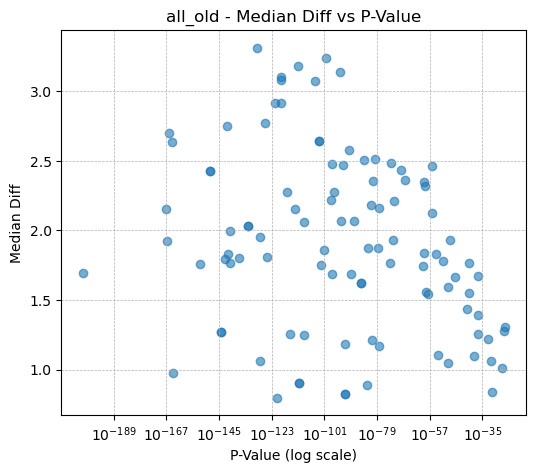


Code name: all_new
Excluded results due to missing fields: 0


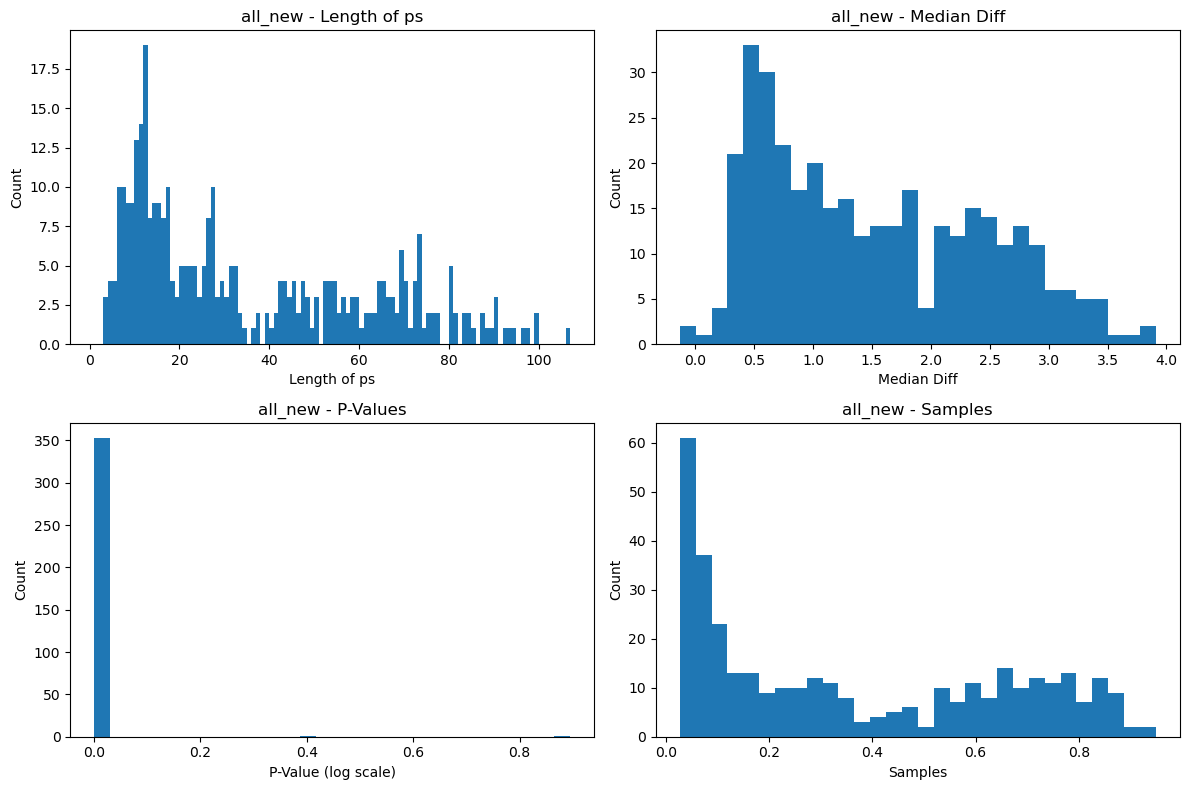

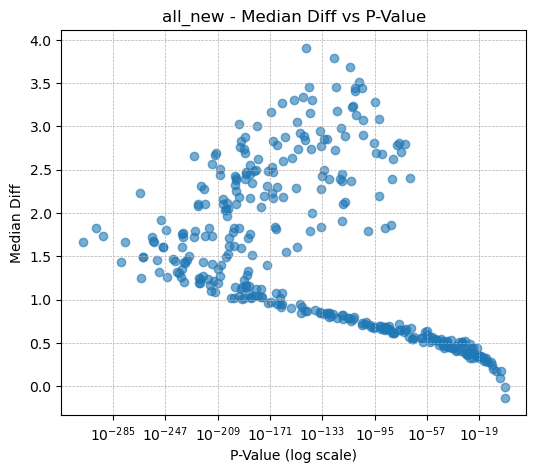

In [12]:
import os
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pathlib import Path

# Set the path to your results folder
results_path = Path(r"C:\Users\gac8\PycharmProjects\PSSearch\initial_testing\data_collection_25_06_9\results\v2") 
json_files = list(results_path.glob("*.json"))

# Storage for grouped data by code_name
data_by_code = defaultdict(list)
excluded_counts = defaultdict(int)

# Read and parse JSON files
for file in json_files:
    with open(file, 'r') as f:
        try:
            data = json.load(f)
        except json.JSONDecodeError:
            print(f"Failed to decode {file}")
            continue
        for entry in data:
            code_name = entry.get("config", {}).get("code_name", "UNKNOWN")
            for result in entry.get("results", []):
                if "median_diff" in result and "p_value" in result:
                    data_by_code[code_name].append(result)
                else:
                    excluded_counts[code_name] += 1

# Plotting
for code_name, results in data_by_code.items():
    print(f"\nCode name: {code_name}")
    print(f"Excluded results due to missing fields: {excluded_counts[code_name]}")
    
    # Extract relevant fields
    ps_lengths = [len(r["ps"]) for r in results]
    median_diffs = [r["median_diff"] for r in results]
    p_values = [r["p_value"] for r in results]
    
    def map_sample(g):
        return 1-(1/(1+g))
    samples = [map_sample(r["samples"]) for r in results]

    # Histogram plots
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.hist(ps_lengths, bins=range(1, max(ps_lengths)+2))
    plt.title(f'{code_name} - Length of ps')
    plt.xlabel("Length of ps")
    plt.ylabel("Count")
    # plt.savefig(f"{code_name}_ps_lengths.png")

    plt.subplot(2, 2, 2)
    plt.hist(median_diffs, bins=30)
    plt.title(f'{code_name} - Median Diff')
    plt.xlabel("Median Diff")
    plt.ylabel("Count")
    # plt.savefig(f"{code_name}_median_diff.png")

    plt.subplot(2, 2, 3)
    plt.hist(p_values, bins=30)
    #plt.xscale('log')
    plt.title(f'{code_name} - P-Values')
    plt.xlabel("P-Value (log scale)")
    plt.ylabel("Count")
    # plt.savefig(f"{code_name}_p_values.png")

    plt.subplot(2, 2, 4)
    plt.hist(samples, bins=30)
    plt.title(f'{code_name} - Samples')
    plt.xlabel("Samples")
    plt.ylabel("Count")
    # plt.savefig(f"{code_name}_samples.png")

    plt.tight_layout()
    plt.show()

    # Scatter plot: p_value (log) vs median_diff
    plt.figure(figsize=(6, 5))
    plt.scatter(p_values, median_diffs, alpha=0.6)
    plt.xscale('log')
    plt.title(f'{code_name} - Median Diff vs P-Value')
    plt.xlabel("P-Value (log scale)")
    plt.ylabel("Median Diff")
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    # plt.savefig(f"{code_name}_scatter_pval_vs_median_diff.png")
    plt.show()